# Overview
This notebook introduces you MONAI's image transformation module.

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import sys
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import monai
from monai.transforms import \
    LoadNifti, LoadNiftid, AddChanneld, ScaleIntensityRanged, \
    Rand3DElasticd, RandAffined, \
    Spacingd, Orientationd

monai.config.print_config()

MONAI version: 0.1.0+214.g9fba24c.dirty
Python version: 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31)  [GCC 7.3.0]
Numpy version: 1.17.4
Pytorch version: 1.5.1

Optional dependencies:
Pytorch Ignite version: 0.3.0
Nibabel version: 3.0.1
scikit-image version: 0.15.0
Pillow version: 7.0.0
Tensorboard version: 2.1.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Data sources
Starting from a list of filenames. The Spleen dataset can be downloaded from http://medicaldecathlon.com/.

The following is a simple python script
to group pairs of image and label from `Task09_Spleen/imagesTr` and `Task09_Spleen/labelsTr`
folder. 

In [2]:
data_root = '/workspace/data/medical/Task09_Spleen'

import os
import glob
train_images = sorted(glob.glob(os.path.join(data_root, 'imagesTr', '*.nii.gz')))
train_labels = sorted(glob.glob(os.path.join(data_root, 'labelsTr', '*.nii.gz')))
data_dicts = [{'image': image_name, 'label': label_name}
              for image_name, label_name in zip(train_images, train_labels)]
train_data_dicts, val_data_dicts = data_dicts[:-9], data_dicts[-9:]

The image file names are organised into a list of dictionaries.

In [3]:
train_data_dicts[0]

{'image': '/workspace/data/medical/Task09_Spleen/imagesTr/spleen_10.nii.gz',
 'label': '/workspace/data/medical/Task09_Spleen/labelsTr/spleen_10.nii.gz'}

The list of data dictionaries, `train_data_dicts`, could be used by
PyTorch's data loader.

For example,

```python
from torch.utils.data import DataLoader

data_loader = DataLoader(train_data_dicts)
for training_sample in data_loader:
    # run the deep learning training with training_sample
```

The rest of this tutorial presents a set of "transforms"
converting `train_data_dict` into data arrays that
will eventually be consumed by the deep learning models.

## Load the NIfTI files

One design choice of MONAI is that it provides not only the high-level workflow components,
but also relatively lower level APIs in their minimal functioning form.

For example, a `LoadNifti` class is a simple callable wrapper of the underlying `Nibabel` image loader.
After constructing the loader with a few necessary system parameters,
calling the loader instance with a NIfTI filename will return the image data arrays, as well as the metadata -- such as affine information and voxel sizes.

In [4]:
loader = LoadNifti(dtype=np.float32)

In [5]:
image, metadata = loader(train_data_dicts[0]['image'])
print('input:', train_data_dicts[0]['image'])
print('image shape', image.shape)
print('image affine', metadata['affine'])
print('image pixdim', metadata['pixdim'])

input: /workspace/data/medical/Task09_Spleen/imagesTr/spleen_10.nii.gz
image shape (512, 512, 55)
image affine [[   0.97656202    0.            0.         -499.02319336]
 [   0.            0.97656202    0.         -499.02319336]
 [   0.            0.            5.            0.        ]
 [   0.            0.            0.            1.        ]]
image pixdim [1.       0.976562 0.976562 5.       0.       0.       0.       0.      ]


Oftentimes, we want to load a group of inputs as a training sample.
For example training a supervised image segmentation network requires a pair of image and label as a training sample.

To ensure a group of inputs are beining preprocessed consistently,
MONAI also provides dictionary-based interfaces for the minimal functioning transforms.

`LoadNiftid` is the corresponding dict-based version of `LoadNifti`:

In [6]:
loader = LoadNiftid(keys=('image', 'label'))

In [7]:
data_dict = loader(train_data_dicts[0])
print('input:', train_data_dicts[0])
print('image shape', data_dict['image'].shape)
print('label shape', data_dict['label'].shape)
print('image pixdim', data_dict['image_meta_dict']['pixdim'])

input: {'image': '/workspace/data/medical/Task09_Spleen/imagesTr/spleen_10.nii.gz', 'label': '/workspace/data/medical/Task09_Spleen/labelsTr/spleen_10.nii.gz'}
image shape (512, 512, 55)
label shape (512, 512, 55)
image pixdim [1.       0.976562 0.976562 5.       0.       0.       0.       0.      ]


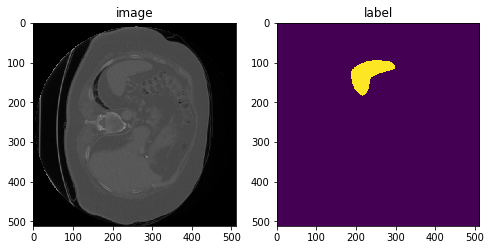

In [8]:
image, label = data_dict['image'], data_dict['label']
plt.figure('visualise', (8, 4))
plt.subplot(1, 2, 1)
plt.title('image')
plt.imshow(image[:, :, 30], cmap='gray')
plt.subplot(1, 2, 2)
plt.title('label')
plt.imshow(label[:, :, 30])
plt.show()

## Add the channel dimension

Most of MONAI's image transformations assume that the input data has the shape:

`[num_channels, spatial_dim_1, spatial_dim_2, ... ,spatial_dim_n]`

so that they could be interpreted consistently (as "channel-first" is commonly used in PyTorch).

Here the input image has shape `(512, 512, 55)` which isn't in the acceptable shape (missing the channel dimension),

we therefore create a transform which is called to update the shape:

In [9]:
add_channel = AddChanneld(keys=['image', 'label'])
datac_dict = add_channel(data_dict)
print('image shape', datac_dict['image'].shape)

image shape (1, 512, 512, 55)


Now we are ready to do some intensity and spatial transforms.

## Resample to a consistent voxel size

The input volumes might have different voxel sizes.

The following transform is created to normalise the volumes to have (1.5, 1.5, 5.) millimetre voxel size.

The transform is set to read the original voxel size information from `data_dict['image.affine']`,
which is from the corresponding NIfTI file, loaded earlier by `LoadNiftid`.

In [10]:
spacing = Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 5.), mode=('bilinear', 'nearest'))

In [11]:
data_dict = spacing(datac_dict)
print('image shape:', data_dict['image'].shape)
print('label shape:', data_dict['label'].shape)
print('image affine after Spacing\n', data_dict['image_meta_dict']['affine']) 
print('label affine after Spacing\n', data_dict['label_meta_dict']['affine'])

image shape: (1, 334, 334, 55)
label shape: (1, 334, 334, 55)
image affine after Spacing
 [[   1.5           0.            0.         -499.02319336]
 [   0.            1.5           0.         -499.02319336]
 [   0.            0.            5.            0.        ]
 [   0.            0.            0.            1.        ]]
label affine after Spacing
 [[   1.5           0.            0.         -499.02319336]
 [   0.            1.5           0.         -499.02319336]
 [   0.            0.            5.            0.        ]
 [   0.            0.            0.            1.        ]]


To track the spacing changes, the data_dict was updated by `Spacingd`:

- An `image.original_affine` key is added to the `data_dict`, logs the original affine.

- An `image.affine` key is updated to have the current affine.

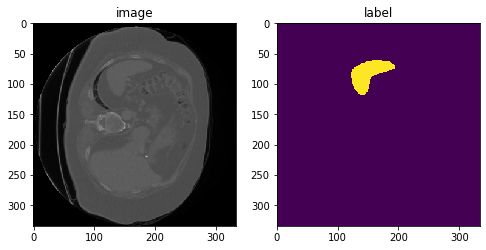

In [12]:
image, label = data_dict['image'], data_dict['label']
plt.figure('visualise', (8, 4))
plt.subplot(1, 2, 1)
plt.title('image')
plt.imshow(image[0, :, :, 30], cmap='gray')
plt.subplot(1, 2, 2)
plt.title('label')
plt.imshow(label[0, :, :, 30])
plt.show()

## Reorientation to a designated axes codes


Sometimes it is nice to have all the input volumes in a consistent axes orientation.

The default axis labels are Left (L), Right (R), Posterior (P), Anterior (A), Inferior (I), Superior (S).

The following transform is created to reorientate the volumes to have 'Posterior, Left, Inferior' (PLI) orientation:

In [13]:
spacing = Orientationd(keys=['image', 'label'], axcodes='PLI')

In [14]:
data_dict = spacing(data_dict)
print('image shape:', data_dict['image'].shape)
print('label shape:', data_dict['label'].shape)
print('image affine after Spacing\n', data_dict['image_meta_dict']['affine']) 
print('label affine after Spacing\n', data_dict['label_meta_dict']['affine'])

image shape: (1, 334, 334, 55)
label shape: (1, 334, 334, 55)
image affine after Spacing
 [[  0.          -1.5          0.           0.47680664]
 [ -1.5          0.           0.           0.47680664]
 [  0.           0.          -5.         270.        ]
 [  0.           0.           0.           1.        ]]
label affine after Spacing
 [[  0.          -1.5          0.           0.47680664]
 [ -1.5          0.           0.           0.47680664]
 [  0.           0.          -5.         270.        ]
 [  0.           0.           0.           1.        ]]


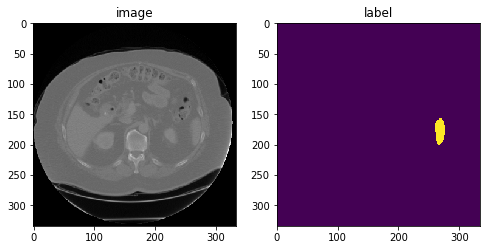

In [15]:
image, label = data_dict['image'], data_dict['label']
plt.figure('visualise', (8, 4))
plt.subplot(1, 2, 1)
plt.title('image')
plt.imshow(image[0, :, :, 30], cmap='gray')
plt.subplot(1, 2, 2)
plt.title('label')
plt.imshow(label[0, :, :, 30])
plt.show()

## Random affine transformation

The following affine transformation is defined to output a (300, 300, 50) image patch.

The patch location is randomly chosen in a range of (-40, 40), (-40, 40), (-2, 2) in x, y, and z axes respectively.
The translation is relative to the image centre.

The 3D rotation angle is randomly chosen from (-45, 45) degrees around the z axis, and 5 degrees around x and y axes.

The random scaling factor is randomly chosen from (1.0 - 0.15, 1.0 + 0.15) along each axis.

In [16]:
rand_affine = RandAffined(keys=['image', 'label'], mode=('bilinear', 'nearest'), prob=1.0,
                          spatial_size=(300, 300, 50),
                          translate_range=(40, 40, 2),
                          rotate_range=(np.pi/36, np.pi/36, np.pi*4),
                          scale_range=(0.15, 0.15, 0.15),
                          padding_mode='border')

You can rerun this cell to generate a different randomised version of the original image.

image shape torch.Size([1, 300, 300, 50])


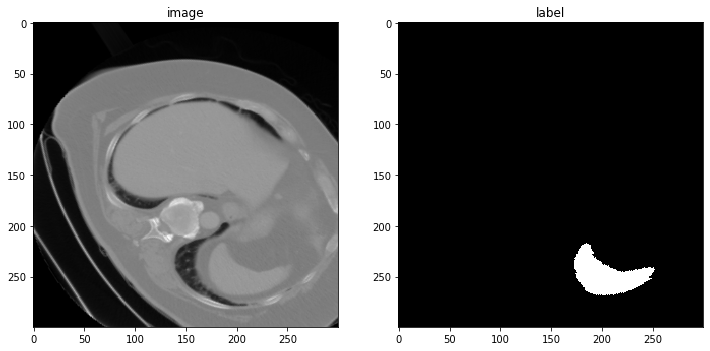

In [17]:
affined_data_dict = rand_affine(data_dict)
print('image shape', affined_data_dict['image'].shape)

image, label = affined_data_dict['image'][0], affined_data_dict['label'][0]
plt.figure('visualise', (12, 6))
plt.subplot(1, 2, 1)
plt.title('image')
plt.imshow(image[:, :, 15], cmap='gray')
plt.subplot(1, 2, 2)
plt.title('label')
plt.imshow(label[:, :, 15], cmap='gray')
plt.show()

## Random elastic deformation

Similarly, the following elastic deformation is defined to output a (300, 300, 10) image patch.

The image is resampled from a combination of affine transformations and elastic deformations.

`sigma_range` controls the smoothness of the deformation (larger than 15 could be slow on CPU)

`magnitude_range` controls the amplitude of the deformation (large than 500, the image becomes unrealistic).

In [18]:
rand_elastic = Rand3DElasticd(
    keys=['image', 'label'], mode=('bilinear', 'nearest'), prob=1.0,
    sigma_range=(5, 8),
    magnitude_range=(100, 200),
    spatial_size=(300, 300, 10),
    translate_range=(50, 50, 2),
    rotate_range=(np.pi/36, np.pi/36, np.pi*2),
    scale_range=(0.15, 0.15, 0.15),
    padding_mode='border')

You can rerun this cell to generate a different randomised version of the original image.

image shape (1, 300, 300, 10)


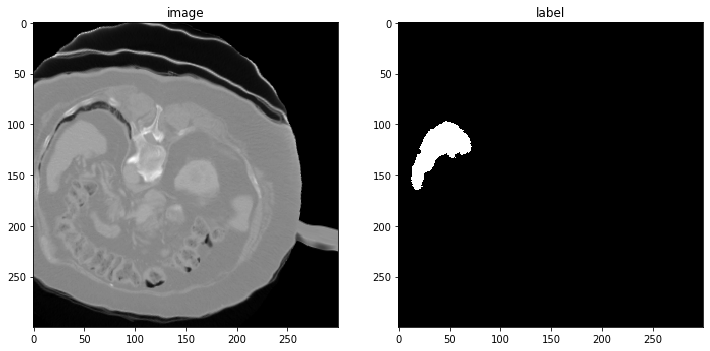

In [22]:
deformed_data_dict = rand_elastic(data_dict)
print('image shape', deformed_data_dict['image'].shape)

image, label = deformed_data_dict['image'][0], deformed_data_dict['label'][0]
plt.figure('visualise', (12, 6))
plt.subplot(1, 2, 1)
plt.title('image')
plt.imshow(image[:, :, 5], cmap='gray')
plt.subplot(1, 2, 2)
plt.title('label')
plt.imshow(label[:, :, 5], cmap='gray')
plt.show()